In [18]:
import pandas as pd
import json
import nltk

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import pickle

# Importing Data

In [2]:
reviews = pd.read_json('IMDB_reviews.json',lines = True)
details = pd.read_json('IMDB_movie_details.json',lines = True)

In [3]:
reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [6]:
reviews.drop(['review_date','user_id','review_summary','rating'],axis = 1, inplace = True)

In [7]:
reviews.head()

,movie_id,is_spoiler,review_text
0,tt0111161,True,"In its Oscar year, Shawshank Redemption (writt..."
1,tt0111161,True,The Shawshank Redemption is without a doubt on...
2,tt0111161,True,I believe that this film is the best story eve...
3,tt0111161,True,"**Yes, there are SPOILERS here**This film has ..."
4,tt0111161,True,At the heart of this extraordinary movie is a ...


In [8]:
details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [9]:
details.drop(['plot_summary','duration','genre','rating','release_date'],axis = 1,inplace = True)

In [10]:
details.head()

,movie_id,plot_synopsis
0,tt0105112,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,Four boys around the age of 10 are friends in ...
2,tt0243655,
3,tt0040897,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Jim McAllister (Matthew Broderick) is a much-a...


# Cleaning Data

In [18]:
details = details[details['plot_synopsis'] != '']

In [19]:
details.head()

,movie_id,plot_synopsis
0,tt0105112,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,Four boys around the age of 10 are friends in ...
3,tt0040897,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Jim McAllister (Matthew Broderick) is a much-a...
5,tt0286716,Bruce Banner (Eric Bana) is a research scienti...


In [30]:
import string

def remove_punc(txt):
    new_txt = ""
    punctuation = string.punctuation
    for letter in txt:
        if letter == '.' or letter == '*':
            new_txt += ''
        elif letter not in punctuation and letter != '.':
            new_txt += letter.lower()
    return new_txt

In [31]:
import re

def tokenize(txt):
    tokens = re.split(' ',txt)
    return tokens

In [32]:
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]

In [33]:
Lem = nltk.WordNetLemmatizer()

def lemmatize_text(tokens):
    return [Lem.lemmatize(word) for word in tokens]

In [35]:
reviews['review_text'] = reviews['review_text'].apply(lambda x: remove_punc(x))
details['plot_synopsis'] = details['plot_synopsis'].apply(lambda x: remove_punc(x))

In [37]:
reviews['review_text'] = reviews['review_text'].apply(lambda x: tokenize(x))
details['plot_synopsis'] = details['plot_synopsis'].apply(lambda x: tokenize(x))

In [41]:
reviews['review_text'] = reviews['review_text'].apply(lambda x: remove_stopwords(x))
details['plot_synopsis'] = details['plot_synopsis'].apply(lambda x: remove_stopwords(x))

In [43]:
reviews['review_text'] = reviews['review_text'].apply(lambda x: lemmatize_text(x))
details['plot_synopsis'] = details['plot_synopsis'].apply(lambda x: lemmatize_text(x))

# Model Development

In [3]:
combined = pd.merge(reviews,details)
combined.drop('movie_id',axis = 1,inplace = True)
combined['is_spoiler'] = combined['is_spoiler'].astype('int')
combined.head()

,is_spoiler,review_text,plot_synopsis
0,1,"['oscar', 'year', 'shawshank', 'redemption', '...","['1947', 'andy', 'dufresne', 'tim', 'robbins',..."
1,1,"['shawshank', 'redemption', 'without', 'doubt'...","['1947', 'andy', 'dufresne', 'tim', 'robbins',..."
2,1,"['believe', 'film', 'best', 'story', 'ever', '...","['1947', 'andy', 'dufresne', 'tim', 'robbins',..."
3,1,"['yes', 'spoiler', 'herethis', 'film', 'emotio...","['1947', 'andy', 'dufresne', 'tim', 'robbins',..."
4,1,"['heart', 'extraordinary', 'movie', 'brilliant...","['1947', 'andy', 'dufresne', 'tim', 'robbins',..."


In [5]:
X = combined.drop('is_spoiler',axis = 1)
y = combined['is_spoiler']

In [6]:
cv = CountVectorizer()
ct = make_column_transformer((cv,'review_text'),(cv,'plot_synopsis'))
X = ct.fit_transform(X)

In [7]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [13]:
lr_200_sag = LogisticRegression(solver = 'sag',max_iter = 200)
lr_200_sag.fit(X_train,y_train)
lr_200_sag.score(X_test,y_test)

c:\users\akhil\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7755795912610332

In [14]:
pickle.dump(lr_200_sag,open('lr_200_sag.pkl','wb'))

# Confusion Matrix

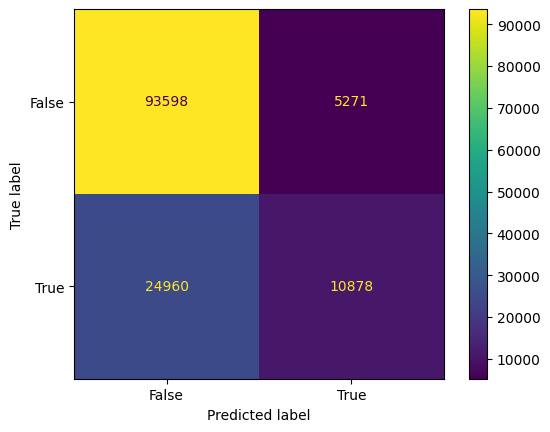

In [20]:
y_pred = lr_200_sag.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                            display_labels = [False, True])
cm_display.plot()
plt.show()